In [129]:
import numpy as np
import pathlib
from datetime import datetime
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Ridge
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt

In [130]:
def load_data(filename, train=True):
    """
    Function loads data stored in the file filename and returns it as a numpy ndarray.
    
    Inputs:
        filename: given as a string
        (optional) train: used to determine whether this is the training or test set
        
    Outputs:
        Data contained in the file, returned as a numpy ndarray
    """
    X = []
    y = []
    with open(filename) as f:
        for line in f:
            if (train):
                # remove \n, split on space, separate into label and weights
                X.append(line.strip().split(' ')[1:])
                y.append(line.strip().split(' ')[0])
            else:
                X.append(line.strip().split(' '))
                
    # convert to np, cast to int, and remove the headers
    X = np.asarray(X[1:]).astype(int)
    if (train):
        y = np.asarray(y[1:]).astype(int)
        
    return X, y

In [131]:
def split_data(x_train, y_train):
    '''
    Function for cross validiation. 
    
    Inputs: 
        x_train: training data points
        y_train: training labels
        
    Outputs:
        trainX: randomized 4/5 of given data points
        trainY: corresponding labels
        testX: randomized 1/5 of given data points
        testY: corresponding lables
    '''
    dataSplit = ShuffleSplit(n_splits = 1, test_size = 0.2)
    for train, test in dataSplit.split(x_train, y_train):
        return x_train[train], y_train[train], x_train[test], y_train[test] 
       

In [132]:
def make_predictions(clf, X, y, test):
    '''
    Function to train and test our classifier
    
    Inputs:
        clf: classifier
        X: data points
        y: labels
        test: test set
    
    Outputs:
        predictions: predictions from running the clf on the test set
    '''
    clf.fit(X, y)
    predictions = clf.predict(test)
    
    return predictions

In [133]:
def save_data(data, filename="%s.txt" % datetime.today().strftime("%X").replace(":", "")):
    '''
    Function to save the predictions by the classifier
    
    Inputs: predictions, (optional) filename
        If filename isn't specified, then it just uses the current time
    
    Outputs: Does not return anything
        Writes the submisssion to a textfile that should have the same format as the sample_submission.txt
    '''
    
    # Creates a new submissions folder if one doesn't exist
    pathlib.Path('submissions').mkdir(parents=True, exist_ok=True)
    with open("submissions\\%s" % filename, "w") as f:
        f.write("Id,Prediction\n")
        for Id, prediction in enumerate(data, 1):
            string = str(Id) + ',' + str(prediction) + '\n'
            f.write(string)
        

In [134]:
def plot_learning_curve(train_errors, validation_errors, vary_param, param_label):
    '''
    Function to plot learning curve for different degrees of regularization

    Inputs:
        train_errors: array of training errors corresponding to various reg_params
        validation_errors: array of validation erros corresponding to various reg_params
        vary_params: array of various values of the varied parameter
        param_label: string input for regularization parameter being varied, e.g. alpha, learning rate
    '''
    plt.figure()
    plt.plot(vary_param, train_errors, c = 'green', label='Training Error')
    plt.plot(vary_param, validation_errors, c = 'red', label='Validation Error')
    plt.scatter(vary_param, train_errors, c = 'green')
    plt.scatter(vary_param, validation_errors, c = 'red')
    plt.xlabel(param_label)
    plt.ylabel('Error')
    plt.legend()
    plt.show()

In [135]:
def vary_alphas(clf, xTrain, yTrain, xTest, yTest, alphas):
    '''
    Function to compute training and validation errors for varied regularization parameter
    
    Inputs:
        clf: classifier
        xTrain: data to train on
        yTrain: labels to training data
        xTest: data to test on (validation set)
        yTest: labels to validation set
        alphas: array of various values of the regularization parameter
        
    Outputs:
        train_errors: array of training errors corresponding to various reg_params
        validation_errors: array of validation erros corresponding to various reg_params
    '''
    training_errors, val_errors = np.zeros(len(alphas)), np.zeros(len(alphas))
    for i in range(len(alphas)):
        clf.set_params(alpha=alphas[i])

        # train and test our model
        train_predictions = make_predictions(clf, xTrain, yTrain, xTrain)
        val_predictions = make_predictions(clf, xTrain, yTrain, xTest)
        # return accuracy
        training_errors[i] = percentError(train_predictions, yTrain)
        val_errors[i] = percentError(val_predictions, yTest)

    plot_learning_curve(training_errors, val_errors, alphas, 'alpha')
    return(training_errors, val_errors)

In [136]:
def vary_learning_rates(clf, xTrain, yTrain, xTest, yTest, learning_rates):
    '''
    Function to compute training and validation errors for varied regularization parameter
    
    Inputs:
        clf: classifier
        xTrain: data to train on
        yTrain: labels to training data
        xTest: data to test on (validation set)
        yTest: labels to validation set
        learning_rates: array of various learning rate values
        
    Outputs:
        train_errors: array of training errors corresponding to various learning rates
        validation_errors: array of validation erros corresponding to various learning rates
    '''
    training_errors, val_errors = np.zeros(len(learning_rates)), np.zeros(len(learning_rates))
    for i in range(len(learning_rates)):
        clf.set_params(learning_rate=learning_rates[i])

        # train and test our model
        train_predictions = make_predictions(clf, xTrain, yTrain, xTrain)
        val_predictions = make_predictions(clf, xTrain, yTrain, xTest)
        # return accuracy
        training_errors[i] = percentError(train_predictions, yTrain)
        val_errors[i] = percentError(val_predictions, yTest)

    plot_learning_curve(training_errors, val_errors, learning_rates, 'Learning Rate')
    return(training_errors, val_errors)

In [137]:
def ridgeReg(xTrain, yTrain, xTest):
    '''
    Function to perform ridge regression. 
    
    Inputs:
        xTrain: data to train on
        yTrain: labels of the training data
        xTest: data to predict on
        
    Outputs:
        predictions: predicted labels of the data
    '''
    cutoff = 0.5
    
    ridge = Ridge(alpha = 200)
    ridge.fit(xTrain, yTrain)
    predictions = ridge.predict(xTest)
    predictions[predictions > cutoff] = 1
    predictions[predictions < cutoff] = 0
    ridgePred = ridgePred.astype(int) # what is this line supposed to do?
    
    return predictions

In [138]:
def percentError(yPred, yTrue):
    '''
    Calculates the percent error between two given label sets
    
    Inputs:
        yTrue: actual labels
    
    Outputs:
        error: float of the number of mismatches divided by total length
    '''     
    return 1-np.sum(np.equal(yPred, yTrue))/len(yTrue)

In [139]:
def gradientBoost(xTrain, yTrain, xTest):
    '''
    Function to perform gradient boost classification. 
    
    Inputs:
        xTrain: data to train on
        yTrain: labels of the training data
        xTest: data to predict on
        
    Outputs:
        predictions: predicted labels of the data
    '''
    clf = GradientBoostingClassifier()
    clf.fit(xTrain, yTrain)
    
    predictions = clf.predict(xTest)
    return predictions

In [140]:
def normalization(X_train, X_test):
    '''
    Function to normalize training and test data

    Inputs:
        X_train: training set data points
        X_test: test set data points

    Outputs:
        train_norm: normalized training set data points
        test_norm: normalized test set data points
    '''
    normalizer = Normalizer().fit(X_train)
    train_norm = normalizer.transform(X_train)
    test_norm = normalizer.transform(X_test)

    return (train_norm, test_norm)

In [141]:
def MLP(xTrain, yTrain, xTest):
    '''
    Function to perform multiple linear perceptron classification. 
    
    Inputs:
        xTrain: data to train on
        yTrain: labels of the training data
        xTest: data to predict on
        
    Outputs:
        predictions: predicted labels of the data
    '''
    mlp = MLPClassifier()
    mlp.fit(xTrain, yTrain)
    predictions = mlp.predict(xTest)
    predictions = predictions.astype(int)
    
    return predictions

In [142]:
def main():
    # load the data
    X_train, y_train = load_data("training_data.txt")
    X_test, _ = load_data("test_data.txt", False)

    # normalize training and test data
    X_train_n, X_test_n = normalization(X_train, X_test)    
    
    # split the data in to training and testing so we can test ourselves
    trainX, trainY, testX, testY = split_data(X_train_n, y_train)

#     # testing ridge regression and the percent error function
#     ridgePred = ridgeReg(trainX, trainY, testX)
#     print("Ridge Regression Error:")
#     print(percentError(ridgePred, testY))

    # testing Gradient Boost
    gradBoostRes = gradientBoost(trainX, trainY, testX)
    print("Gradient Boost Error:")
    print(percentError(gradBoostRes, testY))
    
    # testing MLPClassifier
    mlpPred = MLP(trainX, trainY, testX)
    print("MLP Error:")
    print(percentError(mlpPred, testY))
    
    # testing PassiveAggresiveClassifier
    passiveAggClassclf = PassiveAggressiveClassifier(max_iter=1000)
    print("Passive Aggressive Classifier Error:")
    print(percentError(make_predictions(passiveAggClassclf, trainX, trainY, testX), testY))
    
    # testing and plotting RidgeClassifier for various alphas
    alphas = np.linspace(0.01, 10, 30)
    ridgeClassclf = RidgeClassifier()
    print("Ridge Classifier Error:")
    print(percentError(make_predictions(ridgeClassclf, trainX, trainY, testX), testY))
    vary_alphas(ridgeClassclf, trainX, trainY, testX, testY, alphas)
   
    # testing and plotting AdaBoostClassifier for various steps
    steps = np.linspace(0.01, 10, 30)
    ABClassclf = AdaBoostClassifier()
    print("Adaboost Classifier Error:")
    print(percentError(make_predictions(ABClassclf, trainX, trainY, testX), testY))
    vary_learning_rates(ABClassclf, trainX, trainY, testX, testY, steps)
    
#    # pick our model
#    clf = RandomForestClassifier(n_estimators=5000, criterion = 'gini')
#     # train and test our model
#     predictions = make_predictions(clf, X_train, y_train, X_test)
    clf = RidgeClassifier(alpha=0.35448276)
    predictions = make_predictions(clf, X_train, y_train, X_test)

    # save to a file
    save_data(predictions)

Gradient Boost Error:
0.20475
MLP Error:
0.156
Passive Aggressive Classifier Error:
0.155
Ridge Classifier Error:
0.1455


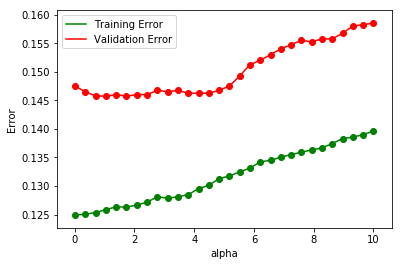

Adaboost Classifier Error:
0.20725


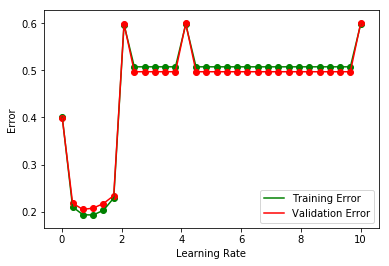

In [143]:
if __name__ == "__main__":
    main()

In [101]:
'''
Tested clfs:
clf = SGDClassifier(loss="log", penalty="l2")
Score: 0.82240

clf = RandomForestClassifier(n_estimators=5000, criterion = 'gini')
Score: 0.82860

'''

'\nTested clfs:\nclf = SGDClassifier(loss="log", penalty="l2")\nScore: 0.82240\n\nclf = RandomForestClassifier(n_estimators=5000, criterion = \'gini\')\nScore: 0.82860\n\n'